In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
isoforest_report.py
- ZIP内CSV（ip,timestamp,lat,lon）に対して Isolation Forest を日別実行
- 解析サマリと異常点CSVを出力
- 件数・異常割合・スコア平均の推移グラフ(PNG)を出力
- 最も異常度が高い上位100件（全日結合）をCSV出力
※ パラメータはハードコーディング
"""
import os, re, zipfile, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import IsolationForest

# ===== ハードコーディング設定 =====
ZIP_PATH   = "isolation_forest.zip"
OUT_DIR    = "isoforest_out"
CONTAM     = 0.10
N_EST      = 200
RANDOM_SEED= 42

# ===== ユーティリティ =====
def ensure_clean_dir(p):
    if os.path.exists(p):
        try:
            import shutil
            shutil.rmtree(p)
        except Exception:
            pass
    os.makedirs(p, exist_ok=True)

def read_csv_fix_header(csv_path: str) -> pd.DataFrame:
    # header=Noneで読み、列名を明示
    df = pd.read_csv(csv_path, header=None)
    df.columns = ["ip", "timestamp", "lat", "lon"]
    # 先頭行がヘッダ文字列なら除去
    if len(df) > 0 and str(df.iloc[0,0]).strip().lower() in ("ip","0"):
        df = df.drop(df.index[0])
    # 型整形
    df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
    df["lon"] = pd.to_numeric(df["lon"], errors="coerce")
    df = df.dropna(subset=["lat","lon"]).reset_index(drop=True)
    return df

def parse_ts_from_filename(fn: str):
    m = re.match(r"^(\d{14})", fn)
    if m:
        return datetime.strptime(m.group(1), "%Y%m%d%H%M%S")
    return None

# ===== メイン処理 =====
def main():
    ensure_clean_dir(OUT_DIR)
    extracted = os.path.join(OUT_DIR, "_extracted")
    ensure_clean_dir(extracted)
    anom_dir = os.path.join(OUT_DIR, "isoforest_anomalies")
    os.makedirs(anom_dir, exist_ok=True)

    if not os.path.exists(ZIP_PATH):
        raise SystemExit(f"ZIP not found: {ZIP_PATH}")

    # ZIP抽出
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(extracted)

    # CSV列挙
    csv_files = []
    for root, _, files in os.walk(extracted):
        for f in files:
            if f.lower().endswith(".csv"):
                csv_files.append(os.path.join(root, f))
    csv_files = sorted(csv_files)

    # 日別にIsolation Forest
    rows = []
    all_anoms = []

    for csv_path in csv_files:
        base = os.path.basename(csv_path)
        try:
            df = read_csv_fix_header(csv_path)
            if len(df) < 10:
                rows.append({"file": base, "count": len(df), "anomaly_ratio": np.nan,
                             "score_mean": np.nan, "score_std": np.nan})
                continue

            X = df[["lat","lon"]].values
            iso = IsolationForest(
                n_estimators=N_EST,
                contamination=CONTAM,
                random_state=RANDOM_SEED,
                n_jobs=-1
            )
            pred  = iso.fit_predict(X)          # 1(正常) / -1(異常)
            score = iso.decision_function(X)    # 大きいほど正常

            out = df.copy()
            out["pred"]  = pred
            out["score"] = score

            # 集計
            count = len(out)
            ar    = float((out["pred"] == -1).mean())
            sm    = float(out["score"].mean())
            ss    = float(out["score"].std(ddof=0))

            # 異常のみ保存
            anom = out[out["pred"] == -1].copy()
            anom["source_file"] = base
            all_anoms.append(anom)
            anom_out = os.path.join(anom_dir, base.replace(".csv", "_anomalies.csv"))
            anom.to_csv(anom_out, index=False, encoding="utf-8")

            rows.append({
                "file": base, "count": count, "anomaly_ratio": round(ar, 6),
                "score_mean": round(sm, 6), "score_std": round(ss, 6)
            })
        except Exception as e:
            rows.append({"file": base, "count": -1, "anomaly_ratio": np.nan,
                         "score_mean": np.nan, "score_std": np.nan, "error": str(e)})

    # サマリ保存
    summary = pd.DataFrame(rows)
    summary["dt"] = summary["file"].apply(parse_ts_from_filename)
    summary = summary.sort_values("dt").reset_index(drop=True)
    summary_path = os.path.join(OUT_DIR, "isoforest_summary.csv")
    summary.to_csv(summary_path, index=False, encoding="utf-8")

    # 全日異常の結合保存＆上位抽出
    worst100_path = None
    all_path = None
    if len(all_anoms) > 0:
        cat = pd.concat(all_anoms, ignore_index=True)
        all_path = os.path.join(OUT_DIR, "isoforest_anomalies_all.csv")
        cat.to_csv(all_path, index=False, encoding="utf-8")
        # より異常（scoreが小さい）上位100件
        worst = cat.sort_values("score").head(100).reset_index(drop=True)
        worst100_path = os.path.join(OUT_DIR, "isoforest_worst100.csv")
        worst.to_csv(worst100_path, index=False, encoding="utf-8")

    # グラフ出力（1枚ずつ）
    def save_lineplot(x, y, title, ylabel, fname):
        plt.figure()
        plt.plot(x, y, marker="o")
        plt.title(title)
        plt.xlabel("datetime")
        plt.ylabel(ylabel)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, fname))
        plt.close()

    save_lineplot(summary["dt"], summary["count"], "count over time", "count", "plot_count.png")
    save_lineplot(summary["dt"], summary["anomaly_ratio"], "anomaly_ratio over time", "anomaly_ratio", "plot_anomaly_ratio.png")
    save_lineplot(summary["dt"], summary["score_mean"], "score_mean over time", "score_mean", "plot_score_mean.png")

    # 出力先を標準出力
    print(summary_path)
    if all_path:
        print(all_path)
    if worst100_path:
        print(worst100_path)
    print(os.path.join(OUT_DIR, "plot_count.png"))
    print(os.path.join(OUT_DIR, "plot_anomaly_ratio.png"))
    print(os.path.join(OUT_DIR, "plot_score_mean.png"))

if __name__ == "__main__":
    main()


isoforest_out\isoforest_summary.csv
isoforest_out\isoforest_anomalies_all.csv
isoforest_out\isoforest_worst100.csv
isoforest_out\plot_count.png
isoforest_out\plot_anomaly_ratio.png
isoforest_out\plot_score_mean.png


C:\Users\flare\AppData\Local\Temp\ipykernel_16412\269451388.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
C:\Users\flare\AppData\Local\Temp\ipykernel_16412\269451388.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
C:\Users\flare\AppData\Local\Temp\ipykernel_16412\269451388.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
C:\Users\flare\AppData\Local\Temp\ipyker

,file,rows,unique_ip,lat_null,lon_null,lat_min,lat_max,lon_min,lon_max,lat_mean,lon_mean,timestamp_min,timestamp_max
0,20251003142418-TorIP_geocoded.csv,1149,1149,14,14,-42.0,65.0,-157.8028,174.0,44.089651,-12.507325,2025-10-01 07:03:32,2025-10-03 04:46:16
1,20251003143810-TorIP_geocoded.csv,1148,1148,14,14,-42.0,65.0,-157.8028,174.0,44.097059,-12.641537,2025-10-01 07:03:32,2025-10-03 04:46:16
2,20251003164852-TorIP_geocoded.csv,1146,1146,14,14,-42.0,65.0,-157.8028,174.0,44.084199,-12.561556,2025-10-01 10:04:18,2025-10-03 07:45:54
3,20251003172946-TorIP_geocoded.csv,1146,1146,14,14,-42.0,65.0,-157.8028,174.0,44.084199,-12.561556,2025-10-01 10:04:18,2025-10-03 07:45:54
4,20251003173524-TorIP_geocoded.csv,1146,1146,14,14,-42.0,65.0,-157.8028,174.0,44.084199,-12.561556,2025-10-01 10:04:18,2025-10-03 07:45:54
5,20251004173514-TorIP_geocoded.csv,1154,1154,16,16,-42.0,65.0,-157.8028,174.0,44.134118,-12.567490,2025-10-02 08:15:09,2025-10-04 07:46:52
6,20251005173523-TorIP_geocoded.csv,1143,1143,15,15,-42.0,65.0,-157.8028,174.0,44.232149,-12.481809,2025-10-03 12:31:43,2025-10-05 07:46:46
7,20251006173520-TorIP_geocoded.csv,1144,1144,15,15,-42.0,65.0,-157.8028,174.0,44.219712,-12.540645,2025-10-04 09:45:26,2025-10-06 07:46:55
8,20251007173522-TorIP_geocoded.csv,1150,1150,15,15,-42.0,65.0,-157.8028,174.0,44.199758,-12.802798,2025-10-05 13:20:36,2025-10-07 07:49:05
9,20251008173518-TorIP_geocoded.csv,1149,1149,15,15,-42.0,65.0,-157.8028,174.0,44.213265,-13.236534,2025-10-06 10:08:37,2025-10-08 07:47:17


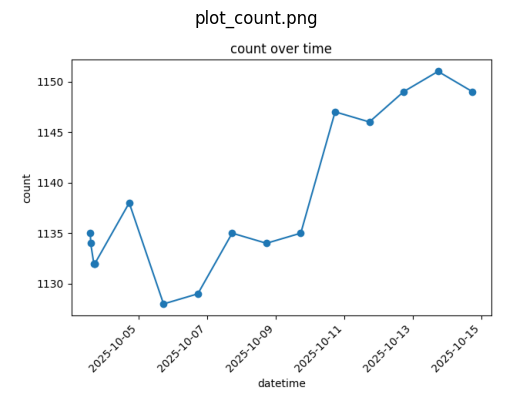

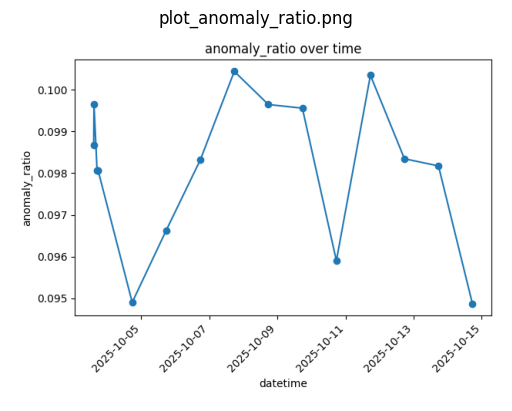

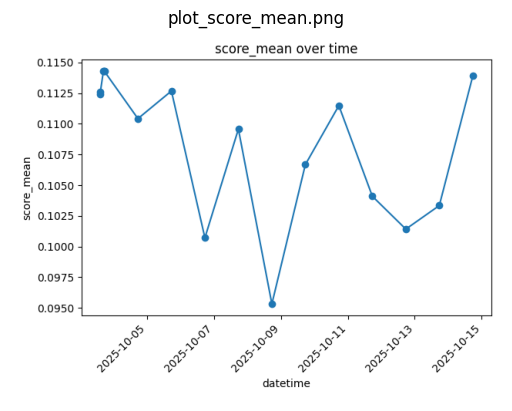

In [4]:
# 各CSVのサマリ & 既存PNGのその場表示（依存なし版）
import os, re, zipfile, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display  # 追加

ZIP_PATH   = "isolation_forest.zip"
OUT_DIR    = "isoforest_out"
EXTRACTED  = os.path.join(OUT_DIR, "_extracted")

def ensure_extracted(zip_path: str, extract_to: str):
    os.makedirs(extract_to, exist_ok=True)
    has_csv = any(
        f.lower().endswith(".csv")
        for _, _, files in os.walk(extract_to)
        for f in files
    )
    if (not has_csv) and os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall(extract_to)

def read_csv_fix_header(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, header=None)
    df.columns = ["ip", "timestamp", "lat", "lon"]
    if len(df) > 0 and str(df.iloc[0,0]).strip().lower() in ("ip","0"):
        df = df.drop(df.index[0])
    df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
    df["lon"] = pd.to_numeric(df["lon"], errors="coerce")
    try:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    except Exception:
        pass
    return df.reset_index(drop=True)

# 1) ZIP展開 & CSV収集
ensure_extracted(ZIP_PATH, EXTRACTED)
csv_files = sorted([
    os.path.join(root, f)
    for root, _, files in os.walk(EXTRACTED)
    for f in files if f.lower().endswith(".csv")
])

# 2) CSVごとのサマリ
rows = []
for p in csv_files:
    try:
        df = read_csv_fix_header(p)
        rows.append({
            "file": os.path.basename(p),
            "rows": len(df),
            "unique_ip": df["ip"].nunique(dropna=True),
            "lat_null": df["lat"].isna().sum(),
            "lon_null": df["lon"].isna().sum(),
            "lat_min": df["lat"].min(),
            "lat_max": df["lat"].max(),
            "lon_min": df["lon"].min(),
            "lon_max": df["lon"].max(),
            "lat_mean": df["lat"].mean(),
            "lon_mean": df["lon"].mean(),
            "timestamp_min": df["timestamp"].min(),
            "timestamp_max": df["timestamp"].max(),
        })
    except Exception as e:
        rows.append({"file": os.path.basename(p), "error": str(e)})

summary_df = pd.DataFrame(rows)
display(summary_df)  # 表示

# 3) PNGをその場で表示
pngs = [
    os.path.join(OUT_DIR, "plot_count.png"),
    os.path.join(OUT_DIR, "plot_anomaly_ratio.png"),
    os.path.join(OUT_DIR, "plot_score_mean.png"),
]
has_png = False
for png in pngs:
    if os.path.exists(png):
        img = plt.imread(png)
        plt.figure()
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(png))
        plt.show()
        has_png = True

if not has_png:
    print("PNGが見つかりません。先に isoforest_report.py を実行してください。")
